## Today, you are becoming a classical music prodigy!

You will learn how to generate classical piano music in the style of different composers like Mozart, Beethoven, and Bach using deep learning. This is an exciting opportunity to use cutting-edge technology to create your own unique pieces of music. 
![Famous Classiscal piano composers](https://www.pianostreet.com/blog/wp-content/uploads/2023/01/12-piano-composers-1.jpg) 
Source: https://www.pianostreet.com/blog/site-news/the-complete-piano-works-of-12-composers-12132/
1. Collect MIDI files for classical piano music pieces written by several different composers. We will provide with the data for this project, but you can also collect your own data if you want to experiment with other composers or genres of music. Therefore download the data from https://www.kaggle.com/datasets/soumikrakshit/classical-music-midi and store it in a folder called "data". The subfolders in the "data" folder should be named after the composers whose music you want to use for training the model. 
![Midi Data Format Represenation: Music is not stored as sound but rather in a format similar to sheet music](https://developer-blogs.nvidia.com/wp-content/uploads/2022/08/image9-3.png) 
Source: https://developer.nvidia.com/blog/leveraging-ai-music-with-nvidia-dgx-2/                                                                                                                                       
2. Use a Python library called "music21" to extract the notes and timing information from your MIDI files. This information will be used as inputs for your neural network.
3. Use PyTorch to build a neural network model that can classify composers from sequences of notes. You will then use the same model architecture to learn the next notes in a piece of music and generate classical piano music in the style of different composers.
4. Your neural network model will consist of an LSTM (Long Short-Term Memory) layer followed by two fully connected layers. You will train the model on your MIDI data and evaluate its performance by generating new pieces of music in the style of the different composers. In case you do not have a GPU you can also load the pretrained mode *best_model.pth* by putting it into your root directory of the notebook.

**To generate new music:**

1. Use a technique called "sampling" where you feed a seed sequence of notes into the trained model, which then generates a new sequence of notes based on its learned patterns. You will repeat this process multiple times to generate longer pieces of music.
2. Use the music21 library to convert the generated sequences of notes back into MIDI files, which can be played back using a digital audio workstation or music software. The resulting output can be used as inspiration for new compositions or as a tool for music education and analysis.

This is a challenging but rewarding project. I am confident that you will be able to generate beautiful and inspiring music using deep learning. So let's get started!

In [3]:

# Define a list of required packages
packages = {
    "music21": "7.3.3",
    "numpy": "1.24.2",
    "pygame": "2.4.0",
    "torch": "2.0.0",
    "matplotlib": "3.7.1",
}


# Install packages# Install packages with specified versions
# for package, version in packages.items():
#     !pip install {package}=={version}

# # Restart the kernel to apply the changes
# import IPython
# app = IPython.Application.instance()
# app.kernel.do_shutdown(True)


In [4]:
import json
import warnings
from collections import Counter
from pathlib import Path
from typing import Dict, List, Tuple, Any

import music21
import numpy as np
import pygame
import torch
from matplotlib import pyplot as plt
from torch import nn
from torch.cuda.amp import autocast
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

warnings.filterwarnings("ignore")
np.random.seed(42)


pygame 2.4.0 (SDL 2.26.4, Python 3.9.13)
Hello from the pygame community. https://www.pygame.org/contribute.html


# Data Collection
In the next step we are collecting the MIDI files for the different composers. We are using the music21 library to load the MIDI files for the different composers. We are using the following composers for this project:
Albeniz, Bach, Balakirev, Beethoven, Borodin, Brahms, Burgmüller, Chopin, Debussy, Granados, Grieg, Haydn, Liszt, Mendelssohn, Mozart, Mussorgsky, Schubert, Schumann, Tchaikovsky




In [5]:
# Here we define the datasets for the different composers



class MidiDataset(Dataset):
    """A dataset of MIDI files.

    Args:
        X (np.ndarray): The features of the dataset.
        y (np.ndarray): The note labels of the dataset.
        composer_name (str): The name of the composer.

    Attributes:
        X (np.ndarray): The features of the dataset.
        y (np.ndarray): The note labels of the dataset.
        composer_name (str): The name of the composer.
        num_samples (int): The number of samples in the dataset.


    """

    def __init__(self, X: np.ndarray, y: np.ndarray, composer_name: str):
        """Initialize the dataset."""
        self.X = X
        self.y = y
        self.composer_name = composer_name
        self.num_samples = len(self.X)


    def __len__(self) -> int:
        """Return the number of samples in the dataset."""
        return self.num_samples

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray]:
        """Return the features and labels for the given index."""
        return self.X[idx], self.y[idx]




# Here we define the datasets for the different composers and merge them into a single dataset for training and testing the model on all the composers together. We also print the length of the corpus and plot the histogram of notes. We can see that the corpus is highly imbalanced with a few notes being very common and most notes being very rare. This is a common problem in music or language and we will deal with it later in the project.

class MultiComposerPianoMidiDataset(Dataset):
    """A dataset of MIDI files from multiple composers.

    Args:
        root_dir (Path): The path to the root directory of the dataset.
        num_most_common_notes (int): The number of most common notes to use.


    Attributes:
        root_dir (Path): The path to the root directory of the dataset.
        all_datasets (List[MidiDataset]): A list of all datasets for each composer.
        num_note_classes (int): The number of classes in the dataset.


        most_common_notes (List[str]): The most common notes in the dataset.
        note_to_label (Dict[str, int]): A mapping from note to label.
        label_to_note (Dict[int, str]): A mapping from label to note.
        composer_to_label (Dict[str, int]): A mapping from composer to label.
        label_to_composer (Dict[int, str]): A mapping from label to composer.
    """

    def __init__(
            self,
            root_dir: Path,
            num_most_common_notes: int=100,
            seq_len: int=40,
    ) -> None:
        """Initialize the dataset."""
        self.root_dir = root_dir
        self.seq_len = seq_len
        self.all_datasets = []

        # Count occurrences of all notes in all composer notes
        all_notes = []
        load_npy = False
        print("Time to grab a coffee. Loading and cleaning the data the first time takes a while (20 minutes). However, you can already start answering the questions! The second time it will be much faster.")
        for composer_dir in self.root_dir.iterdir():

            if not composer_dir.is_dir():
                continue
            if composer_dir.name.startswith('.'):
                continue
            if (composer_dir / "X.npy").is_file():
                load_npy = True
                # Load dataset from saved numpy files
                composer_dataset = MidiDataset(
                    X=np.load(composer_dir / "X.npy"),
                    y=np.load(composer_dir / "y.npy"),
                    composer_name=composer_dir.name
                )
                print(f"Composer {composer_dir.name} has {len(composer_dataset)} sequences/samples")
                for note in composer_dataset.y :
                    all_notes.append(int(note))

                continue
            else:
                print(f"Loading composer data from {composer_dir.name} for data set inspection")
                all_midis = []
                for midi_file in composer_dir.glob("*.mid"):
                    midi = music21.converter.parse(midi_file)
                    all_midis.append(midi)

                all_notes.extend(self.extract_notes(all_midis))
        # plot the histogram, note that just if you create the dataset you actually observe also the rare notes, if you load the dataset from the saved numpy files you only observe the most common notes
        if not load_npy:

            self.plot_histogram_of_notes(all_notes)
            count_num = Counter(all_notes)
            self.most_common_notes = [note for note, count in count_num.most_common(num_most_common_notes)]

            # Create a mapping from note to label
            self.note_to_label = {note: label for label, note in enumerate(self.most_common_notes)}
            self.label_to_note = {label: note for note, label in self.note_to_label.items()}
            self.num_note_classes = len(self.note_to_label)

            # Create a mapping from composer to label
            self.composer_to_label = {composer_dir.name: label for label, composer_dir in enumerate(self.root_dir.iterdir())}
            self.label_to_composer = {label: composer for composer, label in self.composer_to_label.items()}
            self.num_composer_classes = len(self.composer_to_label)

            # save to json file
            self.save_json_files()
        else:
            # load from json file
            self.load_json_files()




        # Iterate over all the composer folders in root_dir
        for i,composer_dir in enumerate(self.root_dir.iterdir()):
            print(f"{composer_dir} {i}")
            if not composer_dir.is_dir():
                continue
            if composer_dir.name.startswith('.'):
                continue
            if (composer_dir / "X.npy").is_file():
                print(f"Loading composer data from {composer_dir.name}")
                # Load dataset from saved numpy files
                composer_dataset = MidiDataset(
                    X=np.load(composer_dir / "X.npy"),
                    y=np.load(composer_dir / "y.npy"),
                    composer_name=composer_dir.name
                )
                self.all_datasets.append(composer_dataset)
                continue
            else:
                # Create a dataset for each composer
                print(f"Creating dataset for composer {composer_dir.name}")
                composer_dataset = self.create_dataset(composer_dir, self.most_common_notes)
                self.all_datasets.append(composer_dataset)

        # Merge all the composer datasets into a single dataset
        self.X = np.concatenate([dataset.X for dataset in self.all_datasets], axis=0)
        self.y_notes = np.concatenate([dataset.y for dataset in self.all_datasets], axis=0)


        # Map a list of composers to labels
        self.composer_list = [dataset.composer_name for dataset in self.all_datasets]
        self.y_composer = np.concatenate(
            [[self.composer_to_label[dataset.composer_name]] * dataset.__len__() for  dataset in self.all_datasets],
            axis=0)[..., np.newaxis]



        # Shuffle the data while preserving the correspondence between inputs and labels
        # this is  important because we split the data into train and test later and we want to have a good distribution of composers in both sets
        indices = np.random.permutation(len(self.X))
        self.X = self.X[indices]
        self.y_notes = self.y_notes[indices]
        self.y_composer = self.y_composer[indices]



    def create_dataset(self, composer_dir: Path, most_common_notes: List[str]) -> MidiDataset:
        """Create a new dataset from MIDI files in `composer_dir`.

        Args:
            composer_dir (Path): The path to the composer directory.
            most_common_notes (List[str]): The most common notes to include in the dataset.

        Returns:
            A `MidiDataset` object.
        """

        # Create new dataset from MIDI files in composer_dir
        all_midis = []
        for midi_file in composer_dir.glob("*.mid"):
            midi = music21.converter.parse(midi_file)
            all_midis.append(midi)

        # Extract notes from all MIDI files
        notes = self.extract_notes(all_midis)


        # Select the most common notes
        selected_notes = [note for note in notes if note in most_common_notes]

        # Map each note to a label
        selected_notes = [self.note_to_label[note] for note in selected_notes]


        # Create a list of features and targets
        features = []
        targets = []

        for i in range(self.seq_len,len(selected_notes)-1):
            feature = selected_notes[i-self.seq_len+1:i + 1]
            target = selected_notes[i + 1]
            features.append(feature)
            targets.append(target)




        # Convert the features and targets to NumPy arrays
        features = np.array(features)
        targets = np.array(targets)


        # Save the dataset to a file
        self.save_to_np(composer_dir,(features, targets))

        # Create a `MidiDataset` object
        dataset = MidiDataset(features, targets, composer_dir.name)

        return dataset


    def extract_notes(self,all_midis: List[music21.stream.Score]) -> List[str]:
        """
        Extract notes from all MIDI files.

        Args:
            all_midis (List[music21.stream.Score]): A list of MIDI files.

        Returns:
            A list of notes.
        """


        notes = []
        pick = None
        for midi in all_midis:
            songs = midi.parts.stream()
            for part in songs:
                pick = part.recurse()
                for element in pick:
                    if isinstance(element, int):
                        notes.append(music21.note.Note.pitch.midiToNoteName(element))
                    elif isinstance(element, music21.note.Note):
                        if element.pitch.name:  # Skip empty notes
                            notes.append(str(element.pitch))
                    elif isinstance(element, music21.chord.Chord):
                        chord_notes = [str(n) for n in element.pitches if n.name]  # Skip empty notes
                        if chord_notes:
                            notes.append(".".join(chord_notes))
        print(f"Number of notes extracted: {len(notes)}")
        return notes

    def plot_histogram_of_notes(self, notes: List[Any]) -> None:
        """Plot a histogram of notes.

        Args:
            notes (List[str]): A list of notes.
        """
        print("Note that the histogram is only displayed the first time you load the data. Afterwards the data is not laoded from the .mid files, but directly from clean .np-files that contain only the most frequent notes.")

        note_counts = Counter(notes)
        sorted_note_counts = sorted(note_counts.items(), key=lambda x: x[1], reverse=True)
        sorted_frequencies = [count for note, count in sorted_note_counts]
        num_notes = len(sorted_frequencies)

        bins = num_notes // 20

        plt.hist(sorted_frequencies, bins=bins)
        plt.xlabel("Number of Notes")
        plt.ylabel("Frequency (#Counts)")
        plt.title("Histogram of Notes")
        plt.xscale('log')
        plt.yscale('log')
        plt.xticks(np.logspace(0, 4, num=5), rotation=45)
        plt.tight_layout()

        plt.show()
        plt.savefig("histogram_of_notes.png")

    def __len__(self) -> int:
        """Return the number of samples in the dataset.

        Returns:
            The number of samples in the dataset.
        """

        return len(self.X)

    def __getitem__(self, idx: int) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """Return the features, target notes, and composer labels for the given index.

        Args:
            idx (int): The index of the sample to return.

        Returns:
            A tuple of features, target notes, and composer labels.
        """

        return self.X[idx], self.y_notes[idx], self.y_composer[idx]
    def save_json_files(self):
        """Saves all the json files in the self.root_dir of the data.

        """

        # Save the note to label mapping.
        with open( "note_to_label.json", "w") as fp:
            json.dump(self.note_to_label, fp)

        # Save the label to note mapping.
        with open("label_to_note.json", "w") as fp:
            json.dump(self.label_to_note, fp)

        # Save the composer to label mapping.
        with open("composer_to_label.json", "w") as fp:
            json.dump(self.composer_to_label, fp)

        # Save the label to composer mapping.
        with open( "label_to_composer.json", "w") as fp:
            json.dump(self.label_to_composer, fp)

        # Save the most common notes.
        with open("most_common_notes.json", "w") as fp:
            json.dump(self.most_common_notes, fp)

    def load_json_files(self):
        """Loads all the json files in the self.root_dir of the data.

        """

        # Load the note to label mapping.
        with open( "note_to_label.json", "r") as fp:
            self.note_to_label = json.load(fp)

        # Load the label to note mapping.
        with open("label_to_note.json", "r") as fp:
            self.label_to_note = json.load(fp)

        # Load the composer to label mapping.
        with open( "composer_to_label.json", "r") as fp:
            self.composer_to_label = json.load(fp)

        # Load the label to composer mapping.
        with open("label_to_composer.json", "r") as fp:
            self.label_to_composer = json.load(fp)

        # Load the most common notes.
        with open( "most_common_notes.json", "r") as fp:
            self.most_common_notes = json.load(fp)

        self.num_note_classes = len(self.note_to_label)
        self.num_composer_classes = len(self.composer_to_label)


        # Convert keys to integers (they are strings when loaded from json)
        self.label_to_note= {int(label): note for label, note in self.label_to_note.items()}
        self.note_to_label = {note: int(label) for note, label in self.note_to_label.items()}
        self.label_to_composer = {int(label): composer for label, composer in self.label_to_composer.items()}
        self.composer_to_label = {composer: int(label) for composer, label in self.composer_to_label.items()}



    def save_to_np(self, componist_folder: Path, data: Tuple[np.ndarray, np.ndarray]) -> None:
        """Save the dataset to NumPy files.

        Args:
            componist_folder (Path): The path to the composer directory.
            data (Tuple[np.ndarray, np.ndarray]): A tuple of features and target notes.
        """

        path_X = componist_folder / "X.npy"
        path_y = componist_folder / "y.npy"
        np.save(path_X, data[0])
        np.save(path_y, data[1])

    def load_from_np(self, componist_folder: Path) -> None:
        """Load the dataset from NumPy files.

        Args:
            componist_folder (Path): The path to the composer directory.
        """

        path_X = componist_folder / "X.npy"
        path_y = componist_folder / "y.npy"
        self.X = np.load(path_X)
        self.y = np.load(path_y)





In [6]:

# here we define the collate function that is used to combine the data samples into a batch for the dataloader
# the collate function yields a tuple of the inputs and labels for each batch. the inputs a sequence of notes and the labels are a dict of the next note in the sequence and the composer label


def collate_fn_notes_componist_labels(batch: List[Tuple[torch.Tensor, torch.Tensor, torch.Tensor]]) -> Tuple[torch.Tensor, Dict[str, torch.Tensor]]:
    """
    Collates a batch of data for training or evaluation.

    Args:
        batch: A list of tuples of (inputs, labels_notes, labels_componist).

    Returns:
        A tuple of (inputs, labels).
    """

    # Get the inputs and labels from the batch.
    inputs, labels_notes, labels_componist = zip(*batch)

    # Convert inputs and labels to float tensors.
    inputs = [torch.from_numpy(x).float() for x in inputs]
    labels_notes = [float(y) for y in labels_notes]
    labels_componist = [torch.from_numpy(y).float() for y in labels_componist]




    # Stack inputs and labels into tensors.
    inputs = torch.stack(inputs).unsqueeze(2)  # add channel dimension
    labels_notes = torch.tensor(labels_notes)
    labels_componist = torch.tensor(labels_componist)
    labels = {"notes": labels_notes, "composers": labels_componist}

    return inputs, labels





In [7]:
# here we define the LSTM model that we will use to predict the next note in the sequence and the composer of the sequence of notes (componist classification)


class LSTM(nn.Module):
    """A long short-term memory (LSTM) model.

    Args:
        input_size: The size of the input tensor.
        hidden_size: The size of the hidden state.
        num_layers: The number of LSTM layers.
        num_notes: The number of output classes for the note classification task.
        num_componists: The number of output classes for the composer classification task.

    """

    def __init__(self, input_size: int, hidden_size: int, num_layers: int, num_notes: int, num_componists: int) -> None:
        super(LSTM, self).__init__()

        # Parameters
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_notes = num_notes
        self.num_componists = num_componists

        # LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Linear layers
        self.ln = nn.LayerNorm(hidden_size)
        self.fc11 = nn.Linear(hidden_size, num_notes)
        self.fc12 = nn.Linear(hidden_size, num_componists)

        # Dropout
        self.dropout = nn.Dropout(p=0.1)

        # ReLU
        self.relu = nn.ReLU()

        # Initialize weights
        for name, param in self.lstm.named_parameters():
            if 'weight' in name:
                torch.nn.init.xavier_normal_(param)
            elif 'bias' in name:
                torch.nn.init.constant_(param, 0.0)

        # Initialize biases of linear layers to 0

        torch.nn.init.constant_(self.fc11.bias, 0.0)
        torch.nn.init.constant_(self.fc12.bias, 0.0)

        # Initialize weights of linear layers with Xavier initialization

        torch.nn.init.xavier_normal_(self.fc11.weight)
        torch.nn.init.xavier_normal_(self.fc12.weight)

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Forward pass of the LSTM model.

        Args:
            x: The input tensor.

        Returns:
            The output tensors for the note classification task and the composer classification task.
        """

        # Set the initial hidden state to 0
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through the LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Apply ReLU
        out = self.relu(out)

        # Normalize the output
        out = self.ln(out)

        # Apply dropout
        out = self.dropout(out)

        # Get the output for the note classification task
        out_notes = self.fc11(out[:, -1, :])

        # Get the output for the composer classification task
        out_composer = self.fc12(out[:, -1, :])

        return out_notes, out_composer



In [8]:
# here a function for creating the dataset and yielding the dataset, samplers and num labels is defined. Note that usually one would try to split sequential data into instances that are not overlapping. For music this owuld mean that one would split the training and test data into non-overlapping sequences of notes, i.e. splitting the pieces or even using different pieces for training and testing. However, for the sake of simplicity we will not do this here.

def create_dataset(root_dir: Path) -> Tuple[MultiComposerPianoMidiDataset,SubsetRandomSampler,SubsetRandomSampler, int, int]:
    """
    Creates a dataset of classical piano music.

    Args:
        root_dir: The path to the directory where the dataset is stored.

    Returns:
        A tuple containing the dataset and the number of classes and composers.
    """

    # Create dataset.
    dataset = MultiComposerPianoMidiDataset(root_dir=root_dir)



    # Create a sampler that samples the first 95% of the data.
    train_sampler = SubsetRandomSampler(list(range(len(dataset)*19 // 20)))

    # Create a sampler that samples the remaining 5% of the data.
    test_sampler = SubsetRandomSampler(list(range(len(dataset)*19 // 20, len(dataset))))

    num_classes = dataset.num_note_classes
    num_composers = dataset.num_composer_classes

    return dataset,train_sampler,test_sampler, num_classes, num_composers


In [9]:
# here we define the function that we will use to load the data. it should take the dataset, the batch size and the samplers as input and return the dataloaders

def create_dataloader(
        dataset: MultiComposerPianoMidiDataset,
        train_sampler: SubsetRandomSampler,
        test_sampler: SubsetRandomSampler,
        batch_size: int,
        num_workers: int = 8,

) -> Tuple[torch.utils.data.DataLoader, torch.utils.data.DataLoader]:
    """
    Creates dataloaders for the dataset.

    Args:
        dataset: The dataset.
        train_sampler: The sampler for the training data.
        test_sampler: The sampler for the validation data.
        batch_size: The batch size to use.
        num_workers: The number of workers to use for loading the data.


    Returns:
        A tuple containing the train and validation dataloaders.
    """

    # Create data loaders.

    train_loader = torch.utils.data.DataLoader(
        dataset, sampler=train_sampler,batch_size=batch_size,  collate_fn=collate_fn_notes_componist_labels, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        dataset, sampler=test_sampler,batch_size=batch_size,  collate_fn=collate_fn_notes_componist_labels
        , num_workers=num_workers
    )

    return train_loader, val_loader



In [10]:
# here we define the validation function that we will use to evaluate the model on the validation set after each epoch of training. it should take logits and labels as input and return the accuracy

def calculate_metric(outputs: torch.Tensor, targets: torch.Tensor) -> float:
    """Calculates the accuracy of the model on the given outputs and targets.

    Args:
        outputs: The model's outputs.
        targets: The ground truth labels.

    Returns:
        The accuracy of the model.
    """

    _, predicted = torch.max(outputs.data, 1)
    total = targets.size(0)
    correct = (predicted == targets).sum().item()
    accuracy = 100 * correct / total
    return accuracy





def visualize_validation_accuracy(val_accuracies: List[float],label_str: str) -> None:
    """Plots the validation accuracy.

    Args:
        val_accuracies: The validation accuracies.

    Returns:
        None.
    """
    plt.close('all')
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies)
    plt.title('Validation Accuracy '+label_str)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.show()





In [11]:
# a function for validation after each epoch is defined here
def validation_after_epoch(
        model: torch.nn.Module,
        val_loader: torch.utils.data.DataLoader,
        best_val_loss: float,
        val_accuracies_note: List[float],
        val_accuracies_composer: List[float],

        device: torch.device,
) -> float:
    """Validates the model after each epoch.

    Args:
        model: The model to validate.
        val_loader: The dataloader for the validation set.
        best_val_loss: The best validation accuracy so far.
        val_accuracies_note: A list to store the validation accuracies for the note classification task.
        val_accuracies_composer: A list to store the validation accuracies for the composer classification task.

    Returns:
        None.
    """

    # Set the model to evaluation mode.

    model.eval()

    # Validate the model.

    with torch.no_grad():
        correct_note, correct_composer = 0, 0
        total_note, total_composer = 0, 0
        loss_note, loss_composer = 0, 0
        for inputs, labels in val_loader:
            inputs = inputs.float().to(device)

            prediction_note, prediction_composer = model(inputs)
            _, predicted_note = torch.max(prediction_note, 1)
            _, predicted_composer = torch.max(prediction_composer, 1)

            total_note += labels["notes"].size(0)
            correct_note += (predicted_note == labels["notes"].to(device)).sum().item()
            total_composer += labels["composers"].size(0)
            correct_composer += (predicted_composer == labels["composers"].to(device)).sum().item()

            loss_note += torch.nn.functional.cross_entropy(prediction_note, labels["notes"].to(device).long(), reduction="mean").item()
            loss_composer += torch.nn.functional.cross_entropy(prediction_composer, labels["composers"].to(device).long(), reduction="mean").item()



        accuracy_note = 100 * correct_note / total_note
        accuracy_composer = 100 * correct_composer / total_composer
        loss_note /= len(val_loader)
        loss_composer /= len(val_loader)
        total_val_loss=loss_note+loss_composer
        val_accuracies_note.append(accuracy_note)
        val_accuracies_composer.append(accuracy_composer)
        print(f"Validation Accuracy Note: {accuracy_note:.2f}%")
        print(f"Validation Accuracy Composer: {accuracy_composer:.2f}%")
        print(f"Validation Loss: {total_val_loss:.2f}")
        print(f"Validation Loss Composer: {loss_composer:.2f}")
        print(f"Validation Loss Note: {loss_note:.2f}")

        # plot the validation accuracy
        # visualize_validation_accuracy(val_accuracies_note,"Note")
        # visualize_validation_accuracy(val_accuracies_composer,"Composer")
        # Save model if validation accuracy has improved.


        if total_val_loss < best_val_loss:
            print("New best model found!\n Saving model...")
            best_val_loss = total_val_loss
            torch.save(model.state_dict(), 'best_model.pth')

    model.train()

    return best_val_loss



In [12]:
# here we define the training function that we will use to train the model. it should take the model, the dataloaders, the optimizer, the loss function (criterion) and the number of epochs as input and return the trained model and the training history (loss and accuracy on the training and validation set)


def train(
        input_size: int,
        hidden_size: int,
        num_layers: int,
        num_epochs: int,
        learning_rate: float,
        train_loader: torch.utils.data.DataLoader,
        val_loader: torch.utils.data.DataLoader,
        num_classes: int,
        num_composers: int,
        device: torch.device,
        model_path:Path,
        fine_tune: bool = False,
        parallel: bool = False,
) -> None:
    """
    Trains a model on the given dataset.

    Args:
        input_size: The size of the input vector.
        hidden_size: The size of the hidden layer.
        num_layers: The number of layers in the model.
        num_epochs: The number of epochs to train for.
        learning_rate: The learning rate to use.
        train_loader: The dataloader for the training set.
        val_loader: The dataloader for the validation set.
        num_classes: The number of classes in the dataset.
        num_composers: The number of composers in the dataset.
        device: The device to train the model on.

    Returns:
        None.
    """




    if device == "cuda" and parallel:
        model = nn.DataParallel(LSTM(input_size, hidden_size, num_layers, num_classes, num_composers)).to(device)
    else:
        model = LSTM(input_size, hidden_size, num_layers, num_classes, num_composers).to(device)
    if fine_tune:
        model.load_state_dict(torch.load(model_path))
        learning_rate = learning_rate / 10




    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5, verbose=True)

    # Train model
    train_losses = []
    val_accuracies_note, val_accuracies_composer = [], []
    best_val_loss = float("inf")

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.float().to(device)

            optimizer.zero_grad()

            with autocast():
                # Forward pass
                prediction_note, prediction_composer = model(inputs)

                loss = criterion(prediction_note, labels["notes"].long().to(device))
                loss += criterion(prediction_composer, labels["composers"].long().to(device))

            # Backward and optimize

            loss.backward()
            optimizer.step()


            if (i + 1) % 100 == 0:
                print(
                    f'Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {loss.item():.4f}')
            train_losses.append(loss.item())
            running_loss += loss.item()

        scheduler.step(running_loss)
        # Validate model after each epoch
        best_val_loss=validation_after_epoch(model, val_loader, best_val_loss, val_accuracies_note, val_accuracies_composer,device)




In [13]:
# this function is for loading the model after the training is done. it should take the model, the path to the model and the device as input and return the model. if you can't train the LSTM model on your machine, you can use the pretrained model that we have provided for you  "best_model.pth"


def load_and_initialize_model(
        model_path: Path,
        num_composers: int,
        num_classes: int,
        device: torch.device,
        input_size: int = 128,
        hidden_size: int = 128,
        num_layers: int = 1,

) -> nn.Module:
    """Loads and initializes a model.

    Args:
        model_path: The path to the model checkpoint.
        num_composers: The number of composers in the dataset.
        num_classes: The number of classes in the dataset.
        input_size: The size of the input vector.
        hidden_size: The size of the hidden layer.
        num_layers: The number of layers in the model.
        device: The device to load the model on.

    Returns:
        The loaded and initialized model.
    """



    # Initialize the model.
    model = LSTM(input_size, hidden_size, num_layers, num_classes, num_composers).to(device)

    # Load the model weights into the model
    model.load_state_dict(torch.load(model_path,map_location=device))

    return model



In [14]:
# this function is for testing the model. it should take the model, the test dataloader and the device as input and return the accuracy on the test set.



def calculate_metrics(normalized_confusion_matrix: torch.Tensor) -> Tuple[float, torch.Tensor, torch.Tensor]:
    """
    Calculate accuracy, precision, and recall metrics from a confusion matrix.

    Args:
        normalized_confusion_matrix (torch.Tensor): The confusion matrix.

    Returns:
        Tuple[float, torch.Tensor, torch.Tensor]: A tuple containing accuracy, precision, and recall.
    """
    # Calculate accuracy
    accuracy = torch.diagonal(normalized_confusion_matrix).sum().item() / normalized_confusion_matrix.sum().item()

    # Calculate precision and recall
    num_classes = normalized_confusion_matrix.size(0)
    precision = torch.zeros(num_classes)
    recall = torch.zeros(num_classes)
    for i in range(num_classes):
        true_positives = normalized_confusion_matrix[i, i].item()
        false_positives = normalized_confusion_matrix[:, i].sum().item() - true_positives
        false_negatives = normalized_confusion_matrix[i, :].sum().item() - true_positives

        precision[i] = true_positives / (true_positives + false_positives + 1e-8)
        recall[i] = true_positives / (true_positives + false_negatives + 1e-8)

    return accuracy, precision, recall


def plot_confusion_matrix(confusion_matrix, composer_to_label, label_to_composer,title):
    """
    Plot a confusion matrix.

    Args:
        confusion_matrix (torch.Tensor): The confusion matrix.
        class_labels (List[str]): The class labels.
        title (str): The title of the plot.
    """


    # Create a figure and axis
    plt.figure(figsize=(10, 8))
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(ticks=np.arange(len(composer_to_label)),
               labels=[composer_to_label[i] for i in
                       range(-1, len(label_to_composer) - 1)], rotation=90)
    plt.yticks(ticks=np.arange(len(composer_to_label)),
               labels=[composer_to_label[i] for i in
                       range(-1, len(label_to_composer) - 1)])
    plt.colorbar()
    plt.show()

    plt.savefig(title + '.png')


def confusion_matrices(model: torch.nn.Module, test_loader: DataLoader, threshold: float):
    """
    Calculate confusion matrices for composer and note predictions.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): DataLoader for the test dataset.
        threshold (float): The threshold for binary classification.

    Returns:
        torch.Tensor: Confusion matrix for composer predictions.
        torch.Tensor: Confusion matrix for note predictions.
    """
    # Initialize confusion matrices
    num_composer_classes = test_loader.dataset.num_composer_classes
    num_note_classes = test_loader.dataset.num_note_classes
    confusion_matrix_composer = torch.zeros(num_composer_classes, num_composer_classes)
    confusion_matrix_note = torch.zeros(num_note_classes, num_note_classes)
    confusion_matrix_composer_argmax = torch.zeros(num_composer_classes, num_composer_classes)
    confusion_matrix_note_argmax = torch.zeros(num_note_classes, num_note_classes)

    # Set model to evaluation mode
    model.eval()

    # Iterate over the test dataset
    for x, y in test_loader:
        x = x
        y_note, y_composer = y["notes"], y["composers"]

        # Forward pass
        with torch.no_grad():
            prediction_note, prediction_composer = model(x)

        # Apply threshold to predictions
        y_hat_note = (prediction_note.sigmoid() > threshold).float()
        y_hat_composer = (prediction_composer.sigmoid() > threshold).float()
        y_hat_note_argmax = prediction_note.argmax(dim=1)
        y_hat_composer_argmax = prediction_composer.argmax(dim=1)

        # One-hot encode targets
        y_note = torch.nn.functional.one_hot(y_note.long(), num_classes=num_note_classes).float()
        y_composer = torch.nn.functional.one_hot(y_composer.long(), num_classes=num_composer_classes).float()

        # Update note confusion matrix
        confusion_matrix_note = torch.add(confusion_matrix_note, torch.matmul(y_note.t(), y_hat_note))

        # Update composer confusion matrix
        confusion_matrix_composer = torch.add(confusion_matrix_composer, torch.matmul(y_composer.t(), y_hat_composer))

        # Update note confusion matrix based on argmax
        confusion_matrix_note_argmax += torch.nn.functional.one_hot(y_hat_note_argmax, num_classes=num_note_classes).float().t() @ y_note

        # Update composer confusion matrix based on argmax
        confusion_matrix_composer_argmax += torch.nn.functional.one_hot(y_hat_composer_argmax, num_classes=num_composer_classes).float().t() @ y_composer

    # Normalize confusion matrices
    normalized_confusion_matrix_composer = confusion_matrix_composer / confusion_matrix_composer.sum(dim=1, keepdim=True)
    normalized_confusion_matrix_note = confusion_matrix_note / confusion_matrix_note.sum(dim=1, keepdim=True)
    normalized_confusion_matrix_composer_argmax = confusion_matrix_composer_argmax / confusion_matrix_composer_argmax.sum(dim=1, keepdim=True)
    normalized_confusion_matrix_note_argmax = confusion_matrix_note_argmax / confusion_matrix_note_argmax.sum(dim=1, keepdim=True)
    plot_list=[normalized_confusion_matrix_composer,normalized_confusion_matrix_composer_argmax]
    if threshold == 0.5:
        for index, confusion_matrix in enumerate(plot_list):
            if index == 0:
                title = 'confusion_matrix_composer_treshold_0.5'
            else:
                title = 'confusion_matrix_composer_argmax'

            # Plot the confusion matrix for the composer predictions
            plt.figure(figsize=(10, 8))
            plt.imshow(confusion_matrix, cmap='Blues')
            plt.title(title)
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.xticks(ticks=np.arange(len(test_loader.dataset.composer_to_label)),
                       labels=[test_loader.dataset.label_to_composer[i] for i in
                               range( len(test_loader.dataset.label_to_composer) )], rotation=90)
            plt.yticks(ticks=np.arange(len(test_loader.dataset.composer_to_label)),
                       labels=[test_loader.dataset.label_to_composer[i] for i in
                               range( len(test_loader.dataset.label_to_composer) )])

            # Annotate the diagonal elements
            for i in range(len(test_loader.dataset.composer_to_label)):
                for j in range(len(test_loader.dataset.composer_to_label)):
                    value = "{:.2f}".format(confusion_matrix[i, j])
                    plt.text(j, i, value, ha='center', va='center', color='white' if i == j else 'black')

            plt.colorbar()
            plt.show()
            plt.savefig(title + '.png')

    return normalized_confusion_matrix_composer, normalized_confusion_matrix_note, normalized_confusion_matrix_composer_argmax, normalized_confusion_matrix_note_argmax


def evaluate_model(
        model: torch.nn.Module,
        test_loader: DataLoader,
        thresholds: List[float]
) -> List[Dict[str, float]]:
    """
    Evaluate the model using different thresholds and calculate performance metrics.

    Args:
        model (torch.nn.Module): The trained model to evaluate.
        test_loader (DataLoader): The data loader for the test dataset.
        thresholds (List[float]): List of thresholds to use for evaluation.

    Returns:
        List[Dict[str, float]]: List of dictionaries containing performance metrics for each threshold.
            Each dictionary includes the following metrics:
                - 'threshold': The threshold used for evaluation.
                - 'composer_accuracy': Accuracy of composer predictions.
                - 'composer_precision': Precision of composer predictions.
                - 'composer_recall': Recall of composer predictions.
                - 'note_accuracy': Accuracy of note predictions.
                - 'note_precision': Precision of note predictions.
                - 'note_recall': Recall of note predictions.
    """

    # Set model to evaluation mode and move it to CPU
    model.eval().cpu()

    # List to store performance metrics for different thresholds
    performance_metrics = []

    for threshold in thresholds:
        print(f"Evaluating model with threshold {threshold:.2f}...")

        # Compute confusion matrices for composer and note predictions
        confusion_matrix_composer, confusion_matrix_note, confusion_matrix_composer_argmax,confusion_matrix_note_argmax = confusion_matrices(model, test_loader, threshold)

        # Calculate metrics for composer predictions
        # Calculate metrics for composer predictions
        composer_accuracy, composer_precision, composer_recall = calculate_metrics(confusion_matrix_composer)
        if threshold == 0.5:
            composer_accuracy_argmax, composer_precision_argmax, composer_recall_argmax = calculate_metrics(
                confusion_matrix_composer_argmax)
            print(f"composer_accuracy_argmax: {composer_accuracy_argmax}")
            print(f"composer_precision_argmax: {composer_precision_argmax}")
            print(f"composer_recall_argmax: {composer_recall_argmax}")

        # Calculate metrics for note predictions
        note_accuracy, note_precision, note_recall = calculate_metrics(confusion_matrix_note)

        # Store performance metrics for the current threshold
        performance_metrics.append({
            'threshold': threshold,
            'composer_accuracy': composer_accuracy,
            'composer_precision': composer_precision,
            'composer_recall': composer_recall,
            'note_accuracy': note_accuracy,
            'note_precision': note_precision,
            'note_recall': note_recall,
        })

    return performance_metrics




def plot_metrics(
        thresholds: List[float],
        accuracy_scores: List[float],
        precision_scores: List[float],
        recall_scores: List[float],
        title: str
) -> None:
    """
    Plot accuracy, precision, and recall for different thresholds.

    Args:
        thresholds (List[float]): List of threshold values.
        accuracy_scores (List[float]): List of accuracy scores.
        precision_scores (List[float]): List of precision scores.
        recall_scores (List[float]): List of recall scores.
        title (str): Title of the plot.

    Returns:
        None
    """
    plt.figure()
    plt.plot(thresholds, accuracy_scores, label='Accuracy', linestyle='-', marker='o')
    plt.plot(thresholds, precision_scores, label='Precision', linestyle='--', marker='s')
    plt.plot(thresholds, recall_scores, label='Recall', linestyle=':', marker='^')
    plt.title(title)
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.legend()
    plt.show()







def calculate_and_visualize_metrics(
        model: torch.nn.Module,
        test_loader: DataLoader,
        thresholds: List[float]
) -> None:
    """
    Calculate and visualize the performance metrics for composer and note predictions.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (DataLoader): The data loader for the test dataset.
        thresholds (List[float]): List of thresholds used for evaluation.

    Returns:
        None
    """

    # Evaluate the model and obtain performance metrics
    performance_metrics = evaluate_model(model, test_loader, thresholds)

    # Extract the thresholds
    thresholds = [metric['threshold'] for metric in performance_metrics]

    # Extract composer scores for each metric
    accuracy_scores = [metric['composer_accuracy'] for metric in performance_metrics]
    precision_scores = [metric['composer_precision'].mean().item() for metric in performance_metrics]
    recall_scores = [metric['composer_recall'].mean().item() for metric in performance_metrics]

    # Plot the composer prediction metrics
    plot_metrics(thresholds, accuracy_scores, precision_scores, recall_scores, title='Composer Prediction Metrics')

    # Extract note scores for each metric
    accuracy_scores = [metric['note_accuracy'] for metric in performance_metrics]
    precision_scores = [metric['note_precision'].mean().item() for metric in performance_metrics]
    recall_scores = [metric['note_recall'].mean().item() for metric in performance_metrics]

    # Plot the note prediction metrics
    plot_metrics(thresholds, accuracy_scores, precision_scores, recall_scores, title='Note Prediction Metrics')


In [15]:
# this function is for creating your own music with the trained model.

def play_midi(midi_file):
    """
    Play a MIDI file using Pygame.
    :param midi_file:
    :return:
    """


    # Initialize Pygame
    pygame.init()

    # Load the MIDI file
    pygame.mixer.music.load(midi_file)

    # Play the MIDI file
    pygame.mixer.music.play()

    # Wait until the music finishes playing
    while pygame.mixer.music.get_busy():
        pygame.time.Clock().tick(10)

    # Quit Pygame
    pygame.quit()








def generate_classical_piano_music(
    model: torch.nn.Module,
    test_loader: torch.utils.data.DataLoader,
    file_path: Path,
    seed: int = 0,
    output_length: int = 10,
        musescore: bool = False
) -> None:
    """
    Generates classical piano music using a trained model.

    Args:
        model (torch.nn.Module): The trained model.
        test_loader (torch.utils.data.DataLoader): The data loader.
        file_path (Path): The file path to save the generated music.
        output_length (int): Length of the output sequence to generate. Default is 100.

    Returns:
        None.
    """

    # Select a random sequence from the validation set to start with.
    validation_set = test_loader.dataset
    np.random.seed(seed)
    start_sequence, _, composer = validation_set[np.random.randint(len(validation_set))]
    print(f"Start sequence is from composer {test_loader.dataset.label_to_composer[composer.item()]}")
    sequence_length = start_sequence.shape[0]

    # Convert the start sequence to notes.
    notes = start_sequence.flatten().tolist()

    model.cpu()
    # Generate music.
    for i in range(output_length):
        # Get the input to the model.
        inputs = torch.tensor(notes[-sequence_length:], dtype=torch.float32).view(1, -1, 1).cpu()

        # Get the output of the model.
        note_pred, composer_pred = model(inputs)

        # Get the probabilities of each note.
        probabilities = torch.softmax(note_pred, dim=1).squeeze().detach().numpy()

        # Choose a note randomly according to the probabilities.
        index = np.random.choice(len(probabilities), p=probabilities)

        # Add the note to the list of notes.
        notes.append(index)

    # Convert labels to notes
    notes = [test_loader.dataset.label_to_note[note] for note in notes]
    print(f"Generated sequence of notes by your neural network: {notes}")
    # Create a MIDI stream.
    midi_stream = music21.stream.Stream()

    # Add the notes to the MIDI stream.
    for note in notes:
        if '.' in note:
            chord_notes = [n for n in note.split('.') if n]  # Skip empty strings
            chord_obj = music21.chord.Chord(chord_notes)
            midi_stream.append(chord_obj)
        else:
            note_obj = music21.note.Note(note)
            midi_stream.append(note_obj)

    # Write the MIDI stream to a file.
    midi_file_path = Path(file_path).resolve()  # Get the absolute path of the file
    midi_file_path.parent.mkdir(parents=True, exist_ok=True)  # Create the parent directory if it doesn't exist
    midi_stream.write('midi', fp=str(midi_file_path))





    # Show the MIDI stream if musescore is installed .
    if musescore:

        # play the music
        play_midi(midi_file_path)
        midi_stream.show()

        # Convert the MIDI file to a WAV file.
        wav_file_path = midi_file_path.with_suffix('.wav')
        music21.converter.parse(str(midi_file_path)).write('wav', fp=str(wav_file_path))


# Summary of the `train` function

The `train` function trains a model to classify notes and composers in piano MIDI music. The function first creates a dataset of MIDI files and splits it into a training set and a validation set. It then creates data loaders for the training and validation sets. Next, the function creates a model and loads the state of the model from a file. It then defines a loss function and an optimizer. The function then trains the model for a specified number of epochs. After each epoch, the function validates the model and saves the model if the validation accuracy has improved. The function returns the training losses and the validation accuracies.

## Steps of the `train` function

1. Create a dataset of MIDI files and split it into a training set and a validation set.
2. Create data loaders for the training and validation sets.
3. Create a model and load the state of the model from a file if `fine_tune` is `True`.
4. Define a loss function and an optimizer.
5. Train the model for a specified number of epochs. IMPORTANT: If you can't train the model set TRAIN to False and load the pretrained model and skip the training steps 6 and 7.
6. After each epoch, validate the model and save the model if the validation accuracy has improved.
7. Return the training losses and the validation accuracies.


## Steps of the `calculate_and_visualize_metrics` function
1. Evaluate the model on the test dataset and obtain performance metrics for different thresholds.
2. Extract the thresholds used for evaluation from the performance metrics.
3. Extract the accuracy, precision, and recall scores for composer predictions.
4. Plot the composer prediction metrics, including accuracy, precision, and recall, for different thresholds.
5. Extract the accuracy, precision, and recall scores for note predictions.
6. Plot the note prediction metrics, including accuracy, precision, and recall, for different thresholds.

## Create your own classical piano music with the `generate_your_own_classical_piano_music` function
1. Generate music.
2. Create a MIDI stream.
3. Add the notes to the MIDI stream.
4. Write the MIDI stream to a file.
5. Show the MIDI stream.


## Exercise Questions

The idea of this exercise is not to do a lot of programming but rather trying to understand the code and the concepts behind it. Therefore, you don't have to write any code for this exercise. 

1. Why do you think we want to use RNN/LSTM for this task and not, for example, a CNN or a fully connected network?

2. What is the difference between the training and validation set?

3. Could you think of other metrics that we could use to evaluate the model?

4. Could you think of other ways to improve the model?

5. Could we use a different loss function for this task? If yes, which one and why?

6. How long are the sequences that we use to train the model?

7. Do you think that the model will perform better if we use longer sequences? If yes, why?

8. Are RNNs hard to train? If yes, why?

9. What are the benefits of using LSTMs over RNNs?

10. What is the difference when performing backpropagation in RNNs and LSTMs compared to fully connected networks?

11. Why might it take quite a long time to train the LSTM model compared to the fully connected network?

12. Why might there be a difference in performance between the composer and note predictions?

13. What might be a better way to split the dataset into training and validation sets?

14. Why is the performance in the confusion matrix for a fixed threshold of 0.5 different from the confusion matrix if we use argmax to predict the class?

15. What might this tell us about the model?

16. If there is a strong off-diagonal component in the confusion matrix of the composers, what might this tell us about the data or the composers?

17. The LSTM model is trained using a batch size of 64. What impact does the batch size have on the training process? How would the training process be affected if we increased or decreased the batch size?

18. In the code, we use dropout regularization with a rate of 0.1. What is the purpose of dropout regularization? How does it help prevent overfitting? Are there any potential drawbacks or limitations of using dropout?

19. The code includes a step where the model's predictions are post-processed using a threshold value. What considerations should be taken into account when choosing an appropriate threshold value? How might the choice of threshold affect the model's performance and the balance between precision and recall?

20. In the code, we evaluate the model's performance using accuracy as a metric. Discuss the limitations of using accuracy as the sole evaluation metric for this classification task. Are there any other evaluation metrics that could provide a more comprehensive assessment of the model's performance?


## Please enter your answer here:
1. RNN's and LSTM's are preferred because these neurons are able to capture temporal dependencies and can capture the trend of the dataset.These networks are better for sequential data because they have internal memory cells so that they can use information from previous steps. 
2. Training dataset is used to train the neural network. Validation dataset is used to compare how accurate the model is by comparing the neural net to the validation dataset on each epoch.
3. Since music is a subjective topic, although it would sound funny, human evaluation would be a good metric.
4. Adding more songs and more composers would improve the results because the model would not only learn the approach of a particular composer, it would also be able to capture the foundations of music theory.
5. A GAN could also be trained. The loss function in GANs usually able to capture reconstruction losses with discriminator. 
6. Seq Length is given as 40.
7. Choosing a sensible sequence length is tricky because it needs to be able to give a sensible trend without including too much randomness. In music, the flow is usually around 4 bars. So 4 bars would be a sensible measure.
8. RNN's are hard to train compared to ANN and CNN because of vanishing/exploding gradients during backpropagation. Also, it takes the data in batches and requires information from previous step. Finally, choosing a right batch size is crucial not to overfit a RNN model.
9. A LSTM is a more complex neuron which has gates inside it. It is able to store forget and update information through these gates. Also, it can handle different lenghts of sequences.
10. RNN's and LSTM's take input as sequences which means each time step is a seperate layer and the connection in between these layers are shared through time. Backpropagation propagates gradients backward through these unfolded layers. Also, as mentioned before LSTM neuron has a complex architecture where it has gates in it. During backpropagation, gradients are propagated through these gates which is different than regular ANN's which does not include gates.
11. LSTM neuron is simply more complex that has different gates thats needs to be updated which makes it automatically more computationally challenging. Secondly, LSTM's tries to learn sequential data so it requires propagating information through time which means that the gradients need to propagate over a larger number of time steps.
12. Eventhough the composers have different perspective in classical music, they are still using similar chords and notes. So the notes are not a clear distinction between the composers. Since notes are not the only thing that distinguishes the composers, differences in performance can be expected.
13. Time-based split would be a better idea because the order and structure of musical notes are crucial for generating sensible sounds. Regular splits might disrupt the temporal dependencies and sequences. 
14. The fixed threshold assumes equal importance to every class which is not correct in most of the scenarios where we are usually left with one class being dominant in the dataset. Argmax selects the class with the highest probability which enables the model to adapt better and make more concrete predictions on the imbalances.
15. If the model accuracy increases using argmax instead of fixed threshold, it can be said that the model is sensitive to class imbalance. In addition, if the argmax increases accuracy, it can be said that the decision boundary is complex and the model is able to succesfuly utilize the complex decision behavior and make accurate predictions.
16. The off-diagonal suggests that the model is making errors. This can be due to the dataset because as mentioned before, the notes are not the only factor that describes the composer's approach to classical music. Since the dataset only has classical music composers and share similar music styles, it is easier to make mistakes. They also influenced each other during their work times which means that there are similarities that the model can not make clear distinctions. Picking the wrong sequence lenght can also make off diagonal measures to increase because the sequence length might simply can't capture the discriminative features.
17. First off, the batch size has a direct impact on the training time. Using larger batch size allows more parallel computing which makes the training faster. Larger batch size also consumes more memory simply because more data and gradients needs to be stored at the same time. Using larger batch size also means that the gradients are computed based on more samples which  provides better estimation results.
18. The main reason to implement dropout is to introduce more randomness to the system where the neurons shut down temporarily which encourages the model to learn more robust features. Dropouts also reduces the risk of the model to memorize on the training data. By shutting down the neurons, the network is forced to learn using different combinations of neurons. 
19. Class imbalance is the first most important point. If the classes are imbalanced, a threshold that is biased towards the majority class might result in higher prediction rate for the dominant class.
20. Accuracy measures the proportion of correct classified samples to the overall dataset but it does not take the class imbalances into consideration. In imbalanced datasets, it is better to use precision or F1 score can be a better indicator.

In [19]:
# here we set the hyperparameters for the training and testing of the model.
# Hyperparameters
INPUT_SIZE = 1
HIDDEN_SIZE = 256
NUM_LAYERS = 2
NUM_WORKERS=16
BATCH_SIZE =  64
LEARNING_RATE = .001
NUM_EPOCHS = 1000
SEQUENCE_LENGTH = 40

# To generate another music sequence change the seed, e.g. 1,2,3,4...
RANDOM_SEED_4_MUSIC_GEN = 0

# Enter the path of your "data" folder 
DATA_DIR = Path(r"C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\data\archive")
MODEL_PATH=Path(r"C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Labs\best_model.pth")
TRAIN_MODEL = False
FINE_TUNE_MODEL = False
PARALLEL= True
MUSE_SCORE = False
MUSIC_FILE_PATH = Path('generated_music.mid')
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [20]:
# this is the main function that will be called when we run the script.

def main():
    """
    This function is the main entry point for the program.

    Returns:
      None.
    """



    # Create dataset.
    dataset, train_sampler,test_sampler, num_classes, num_composers = create_dataset(root_dir=DATA_DIR)

    # Create dataloaders.
    train_loader, val_loader = create_dataloader(dataset=dataset, train_sampler=train_sampler,
                                                 test_sampler=test_sampler, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


    # Train the model if `TRAIN_MODEL` is True.
    if TRAIN_MODEL:


        # Train the model.
        train(train_loader=train_loader,
                      val_loader=val_loader,
                      num_classes=num_classes,
                      num_composers=num_composers,
                      input_size=INPUT_SIZE,
                      hidden_size=HIDDEN_SIZE,
                      num_layers=NUM_LAYERS,
                      learning_rate=LEARNING_RATE,
                      num_epochs=NUM_EPOCHS,
                      device=DEVICE,
                    model_path=MODEL_PATH,
                      fine_tune=FINE_TUNE_MODEL,
                      parallel=PARALLEL,
                      )

    # Load the trained model.
    model = load_and_initialize_model(model_path=MODEL_PATH,
                                      num_composers=num_composers,
                                      num_classes=num_classes,
                                      input_size=INPUT_SIZE,
                                      hidden_size=HIDDEN_SIZE,
                                      num_layers=NUM_LAYERS,
                                      device=DEVICE,)

    # Evaluate the model.
    calculate_and_visualize_metrics(model=model,
                                    test_loader=val_loader,
                                    thresholds=[0.1,0.5,0.9,0.95,0.99,0.999],
                                    )



    # Generate your own classical piano music.
    # if you want to visualize the generated music, set `musescore` to True and make sure you have musescore installed.
    # Otherwise, set `musescore` to False. To install MuseScore on your system, you can visit the MuseScore website (https://musescore.org/) and download the appropriate installer for your operating system. Once installed, you can try running the mscore3 command again to verify its installation.
    generate_classical_piano_music(model=model,
                                            test_loader=val_loader,file_path=MUSIC_FILE_PATH,seed=RANDOM_SEED_4_MUSIC_GEN,musescore=MUSE_SCORE,)

Time to grab a coffee. Loading and cleaning the data the first time takes a while (20 minutes). However, you can already start answering the questions! The second time it will be much faster.
Loading composer data from albeniz for data set inspection
Number of notes extracted: 17545
Loading composer data from bach for data set inspection
Number of notes extracted: 4145
Loading composer data from balakir for data set inspection
Number of notes extracted: 4462
Loading composer data from beeth for data set inspection
Number of notes extracted: 81312
Loading composer data from borodin for data set inspection
Number of notes extracted: 4753
Loading composer data from brahms for data set inspection
Number of notes extracted: 16129
Loading composer data from burgm for data set inspection
Number of notes extracted: 5908
Loading composer data from chopin for data set inspection
Number of notes extracted: 57887
Loading composer data from debussy for data set inspection
Number of notes extracted:

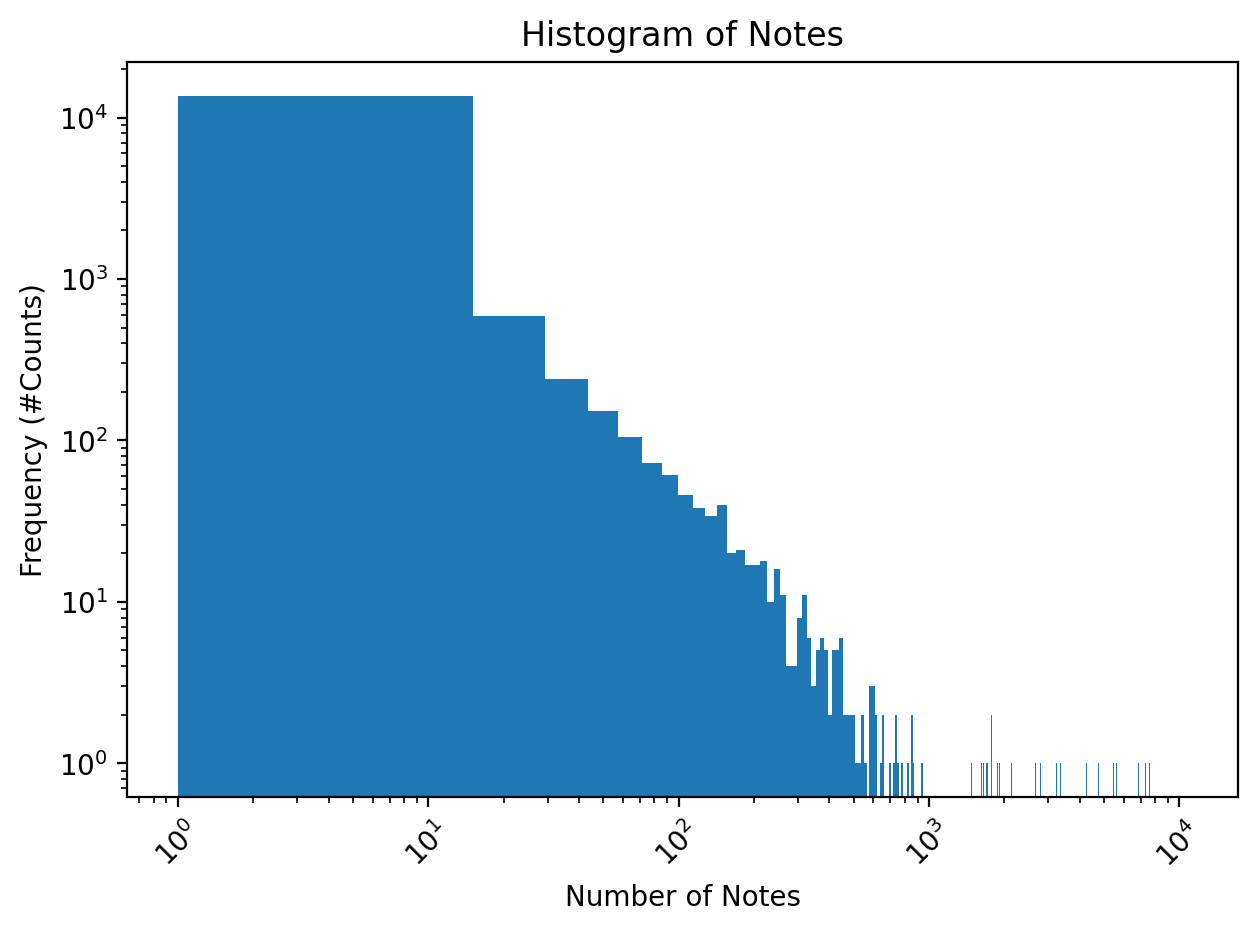

C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\data\archive\albeniz 0
Creating dataset for composer albeniz
Number of notes extracted: 17545
C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\data\archive\bach 1
Creating dataset for composer bach
Number of notes extracted: 4145
C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\data\archive\balakir 2
Creating dataset for composer balakir
Number of notes extracted: 4462
C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\data\archive\beeth 3
Creating dataset for composer beeth
Number of notes extracted: 81312
C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\data\archive\borodin 4
Creating dataset for composer borodin
Number of notes extracted: 4753
C:\Users\tunay\OneDrive\Desktop\github_repos\MachineLearningforSciences\Datasets\data\archive\brahms 5
Creating dataset for composer brahm

In [21]:
# this cell runs the main function.
if __name__ == "__main__":
    main()